# MD: les dry layer assignment solution

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

the_file = Path.home() / "Dropbox/phil_files/a500/data" / "case_60_10.nc"
if not the_file.exists():
    raise ValueError(f"{the_file} not found")

## Find the netcdf file an dump its contents

In [2]:
the_file

PosixPath('/Users/phil/Dropbox/phil_files/a500/data/case_60_10.nc')

In [3]:
!ncdump -h C:/Users/minad/Documents/UBC/ATSC-500/case_60_10.nc

ncdump: C:/Users/minad/Documents/UBC/ATSC-500/case_60_10.nc: No such file or directory


Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.

## Open the first ensemble member c1

Look at the last 5 values of z, pressure

From the ncdump we know that there are global variables and attributes as
well as the 10 ensemble members.  So get two xarray dataset pointers:

- ds1 for the first ensemble member
- the_ds for the global variables

In [4]:
ds1 = xr.open_dataset(the_file,group="c1")
the_ds = xr.open_dataset(the_file)

In [5]:
the_ds['z'][-5:]

<xarray.DataArray 'z' (z: 5)>
array([1025., 1030., 1035., 1040., 1045.], dtype=float32)
Coordinates:
  * z        (z) float32 1.025e+03 1.03e+03 1.035e+03 1.04e+03 1.045e+03
Attributes:
    units:    meters

In [6]:
ds1

<xarray.Dataset>
Dimensions:  (time: 48, z: 130, y: 20, x: 25)
Dimensions without coordinates: time, z, y, x
Data variables:
    TABS     (time, z, y, x) float32 ...
    W        (time, z, y, x) float32 ...
    U        (time, z, y, x) float32 ...
    V        (time, z, y, x) float32 ...

In [7]:
temp = ds1['TABS']
wvel= ds1['W']
z=the_ds['z']
press=the_ds['press']

## dump height and pressure

In [8]:
(z[-5:].data,press[-5:].data)

(array([1025., 1030., 1035., 1040., 1045.], dtype=float32),
 array([88980.79 , 88930.06 , 88879.445, 88828.77 , 88778.21 ],
       dtype=float32))

## Function to convert to $\theta$

In [9]:
def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    
    return theta
    

## Get the horizontal average

In [10]:
temp_mean=temp.mean(dim=["x","y"])

In [11]:
temp_mean[0,-5:]

<xarray.DataArray 'TABS' (z: 5)>
array([299.92114, 299.9195 , 299.918  , 299.91644, 299.9148 ],
      dtype=float32)
Dimensions without coordinates: z

In [12]:
## Plot the timestep theta,height profiles for c1

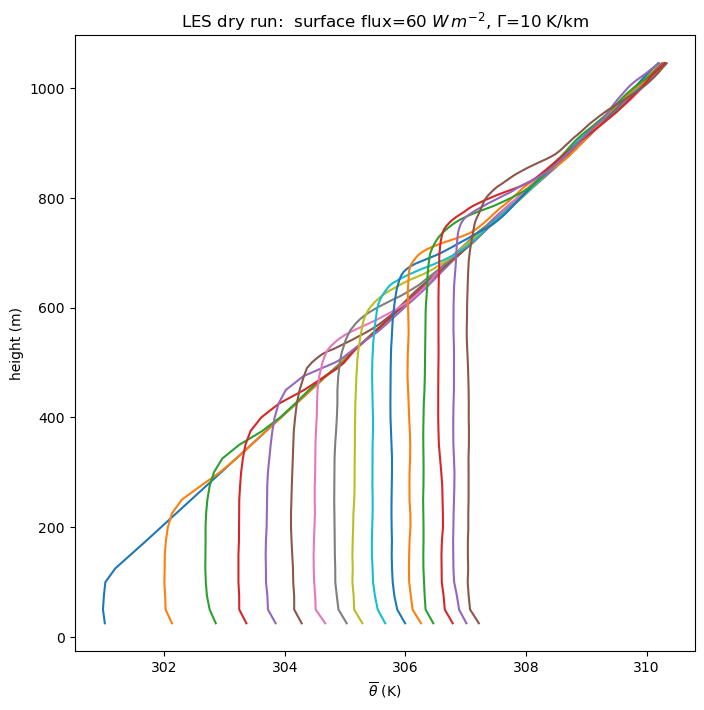

In [13]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ntimes, nheights = temp_mean.shape
for i in np.arange(0,ntimes,3):
    theta = make_theta(temp_mean[i,:],press)
    ax.plot(theta,z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km');

    

## Assignment -- targeting Tuesday

- Write functions that find the ensemble mean $\langle \zeta \rangle$ and the perturbation about that mean $\zeta^\prime$ an arbitrary variable $\zeta$
- Use those functions to calculate the horizontally averaged vertical entropy flux $\overline{w^\prime\,\theta^\prime}$ as a function of height and make a plot similar to the figure above

In [14]:
#Make ensemble members into a dimension for the xarrays
members = ["c" + str(i) for i in np.arange(1,11)]

w_dict = []
for count in range(len(members)):
    ds = xr.open_dataset(the_file,group=members[count])
    w_dict.append(ds['W'])
wds = xr.concat(w_dict,dim='members')

tabs_dict = []
for count in range(len(members)):
    ds = xr.open_dataset(the_file,group=members[count])
    tabs_dict.append(ds['TABS'])
tabsds = xr.concat(tabs_dict,dim='members')

#convert to theta
thetads = make_theta(tabsds,press)
#print(thetads)
#print(tabsds)

#For ref: https://coecms-training.github.io/parallel/case-studies/loading_ensemble.html 

In [15]:
#Get perturbations for w and theta
thetamean = thetads.mean(dim=["members"])
wmean = wds.mean(dim=["members"])

w_per = wds-wmean
theta_per = thetads-thetamean

In [16]:
#w'*theta' - averaged over ensemble members
perturbations = w_per*theta_per
perturbations = perturbations.mean(dim=["members"])

#spatial mean (overbar)
vert_entropy_flux = perturbations.mean(dim=["x","y"])

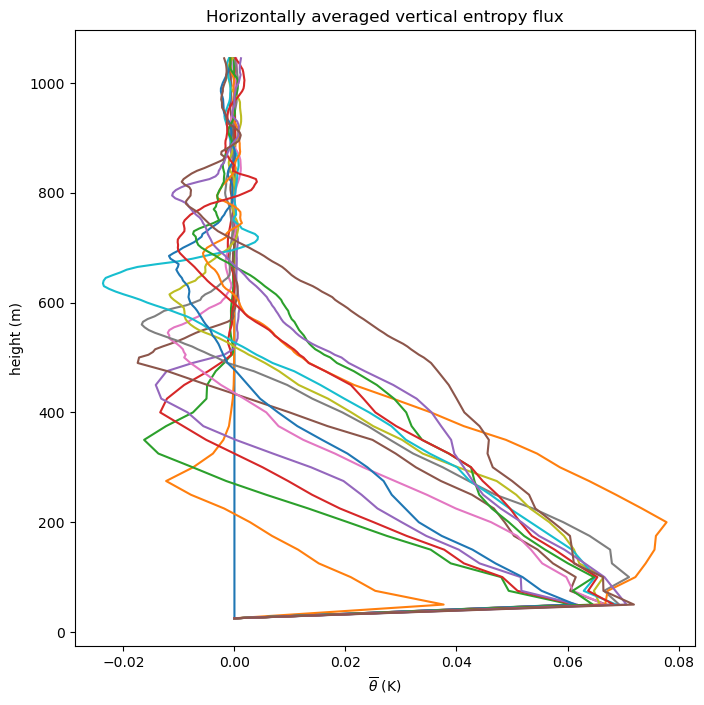

In [17]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ntimes, nheights = vert_entropy_flux.shape
for i in np.arange(0,ntimes,3):
    ax.plot(vert_entropy_flux[i,:],z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='Horizontally averaged vertical entropy flux');
